<a href="https://colab.research.google.com/github/faithrts/Science_Explainers/blob/main/analysis/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [19]:
### importing libraries

# basic libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# to download files
from google.colab import files

import os
import re
import ast
import math
import codecs

# for word2vec
from gensim.models import Word2Vec

# scipy
from scipy.stats import chi2  ## for stats
from scipy import spatial     ## for cosine similarity

# sklearn libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.decomposition import LatentDirichletAllocation

# NLTK
import nltk
from nltk import word_tokenize
from nltk import pos_tag
from nltk.stem import SnowballStemmer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# silencing the warnings
pd.options.mode.chained_assignment = None  # default='warn'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Importing databases

In [20]:
### cloning git repos

!git clone https://github.com/faithrts/Science_Explainers
#!git clone https://github.com/dhmit/gender_novels
#!git clone https://github.com/faithrts/Short_Fiction

fatal: destination path 'Science_Explainers' already exists and is not an empty directory.


In [21]:
### importing dataframes:
# [explainer/fiction]_dtm_df
# [explainer/fiction]_tfidf_df
# [explainer/fiction]_pos_df

explainer_dtm_df = pd.read_csv('Science_Explainers/analysis/explainer_dtm.csv')
explainer_tfidf_df = pd.read_csv('Science_Explainers/analysis/explainer_tfidf.csv')
explainer_pos_df = pd.read_csv('Science_Explainers/analysis/explainer_pos.csv')

fiction_dtm_df = pd.read_csv('Science_Explainers/analysis/fiction_dtm.csv')
fiction_tfidf_df = pd.read_csv('Science_Explainers/analysis/fiction_tfidf.csv')
fiction_pos_df = pd.read_csv('Science_Explainers/analysis/fiction_pos.csv')

## Helper functions

### Data processing

In [25]:
### makes all the column names UPPERCASE
def col_names_to_uppercase(df):
  new_columns = [name.upper() for name in df.columns]
  df.columns = new_columns

  return df

In [26]:
class StemWords(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass

  def fit(self, X, y=None):
    return self

  def transform(self, list_of_passages):
    # initializes the stemmer
    snowball_stemmer = SnowballStemmer('english')
    new_list_of_passages = []

    for passage in list_of_passages:
      # breaks the passage up into its component words
      words = nltk.word_tokenize(passage)
      new_words = [snowball_stemmer.stem(word) for word in words]

      new_passage = ' '.join(new_words)
      new_list_of_passages.append(new_passage)

    return new_list_of_passages

In [27]:
def refine_df_columns(df, list_of_titles):

  # the new df with only the columns to keep
  df_copy = df[list_of_titles]

  return df_copy

### Modelling

In [28]:
### custom pre-processor to eliminte numbers and instances of "_", "\", and "—"
def my_preprocessor(text):
    text = text.lower()
    text = re.sub('([0-9—_\\\\])', '', text)
    return text

In [29]:
def convert_df_to_data(df):
  return df.values.tolist()

In [30]:
def create_and_train_log_reg_l2(x_train, y_train, max_iterations = 5000):

  # logistic regression with l2 regularization
  model = LogisticRegression(penalty = 'l2', max_iter = max_iterations)

  # fitting the model
  model = model.fit(x_train, y_train)

  return model

In [31]:
def create_and_train_lda(x_train, topics = 10, max_iterations = 5000):

  # logistic regression with l2 regularization
  model = LatentDirichletAllocation(n_components = topics, random_state = 11)

  # fitting the model
  model = model.fit_transform(x_train)

  return model

In [119]:
def test_predictive_model(x_test, y_test, model):
  # predicted labels
  y_pred = model.predict(x_test)

  # gets performance in terms of precision, recall, accuracy, etc.
  report = classification_report(y_test, y_pred, target_names = ['e', 'f'], output_dict = True)
  accuracy = round(report.get('accuracy') * 100, 2)

  comparison = y_pred == y_test
  incorrect_indices = [index for index, value in enumerate(comparison) if value == False]

  return y_pred, report, incorrect_indices

In [33]:
def train_test_split_helper(explainer_feature_df, fiction_feature_df, ran = 11):

  # adds the file identity to the end of each datapoint for later identification of miscategorized files
  if 'FILENAME' not in explainer_feature_df.columns:
    explainer_feature_df['FILENAME'] = explainer_dtm_df['FILENAME']
  if 'FILENAME' not in fiction_feature_df.columns:
    fiction_feature_df['FILENAME'] = fiction_dtm_df['FILENAME']

  # converts dataframes into lists of feature values
  explainer_data = convert_df_to_data(explainer_feature_df)
  fiction_data = convert_df_to_data(fiction_feature_df)

  # combines the explainer and fiction data
  total_data = explainer_data + fiction_data
  # creates target labels for the data
  total_labels = ['e'] * len(explainer_data) + ['f'] * len(fiction_data)

  # splits the data into training and testing (random state to keep results consistent across re-runs)
  x_train, x_test, y_train, y_test = train_test_split(total_data, total_labels, random_state = ran)

  # retrieves the filenames for later identification (removes from data before input to model)
  filenames_train = [datapoint.pop() for datapoint in x_train]
  filenames_test = [datapoint.pop() for datapoint in x_test]

  return x_train, x_test, y_train, y_test, filenames_train, filenames_test

In [150]:
from operator import truediv
def run_k_cross_validation(explainer_feature_df, fiction_feature_df, k = 5, ran = 11, model = '', verbose = False):

  accuracies = []
  miscategorized_files = []
  closest_vectors = []
  sim_values = []

  # if the filenames aren't in the feature dataframes, adds them so we can extract at the miscategorized files
  if 'FILENAME' not in explainer_feature_df.columns:
    explainer_feature_df['FILENAME'] = explainer_dtm_df['FILENAME']
  if 'FILENAME' not in fiction_feature_df.columns:
    fiction_feature_df['FILENAME'] = fiction_dtm_df['FILENAME']

  # shuffles the dataframes
  explainer_feature_shuffled_df = explainer_feature_df.sample(frac = 1, random_state = 22)
  fiction_feature_shuffled_df = fiction_feature_df.sample(frac = 1, random_state = 22)

  # converts dataframes into lists of feature values
  explainer_data = convert_df_to_data(explainer_feature_df)
  fiction_data = convert_df_to_data(fiction_feature_df)

  # indices
  partition_size = int(len(explainer_feature_shuffled_df) / (k * 2))

  start = 0
  end = partition_size
  # for folds 0 to k - 1, sets partition i as the test set
  for i in range(k):

    # training data
    x_train_explainer = explainer_data[0:start] + explainer_data[end:-1]
    x_train_fiction = fiction_data[0:start] + fiction_data[end:-1]

    # testing data
    x_test_explainer = explainer_data[start:end]
    x_test_fiction = fiction_data[start:end]

    # combines the explainer and fiction data
    x_train = x_train_explainer + x_train_fiction
    x_test = x_test_explainer + x_test_fiction

    # retrieves the filenames for later identification of miscategorized texts
    filenames_train = [datapoint[-1] for datapoint in x_train]
    filenames_test = [datapoint[-1] for datapoint in x_test]

    # I do this instead of pop as for some reason, pop was modifying the original data
    x_train = [datapoint[:-1] for datapoint in x_train]
    x_test = [datapoint[:-1] for datapoint in x_test]

    y_train = ['e'] * len(x_train_explainer) + ['f'] * len(x_train_fiction)
    y_test = ['e'] * len(x_test_explainer) + ['f'] * len(x_test_explainer)


    ### trains and tests the model

    if model == '':
      # uses default model
      model = LogisticRegression(penalty = 'l2', max_iter = 5000)

    model = model.fit(x_train, y_train)

    # performance report
    y_pred, report, incorrect_indices = test_predictive_model(x_test, y_test, model)
    accuracy = round(report.get('accuracy') * 100, 2)
    accuracies.append(accuracy)

    if verbose and i == 4:
      from sklearn.manifold import MDS
      mds = MDS(random_state=0)
      scaled_test = mds.fit_transform(x_test)

      color1 = (0.69411766529083252, 0.3490196168422699, 0.15686275064945221, 1.0)
      color2 = (0.65098041296005249, 0.80784314870834351, 0.89019608497619629, 1.0)

      not1 = True
      not2 = True
      not3 = True
      not4 = True
      for i in range(len(y_test)):
        if y_test[i] == 'e' and y_pred[i] == 'e':
          col = color1
          edgcol = 'none'
          label = None
          if not1:
            label = 'Explainer'
            not1 = False
        elif y_test[i] == 'e' and y_pred[i] == 'f':
          col = 'pink'
          edgcol = color1
          label = None
          if not2:
            label = 'Miscategorized explainer'
            not2 = False
        elif y_test[i] == 'f' and y_pred[i] == 'f':
          col = color2
          edgcol = 'none'
          label = None
          if not3:
            label = 'Fiction'
            not3 = False
        elif y_test[i] == 'f' and y_pred[i] == 'e':
          col = 'pink'
          edgcol = color2
          label = None
          if not4:
            label = 'Miscategorized fiction'
            not4 = False

        plt.scatter(scaled_test[i,0], scaled_test[i,1], c = col, edgecolors = edgcol, label = label)

      for i, txt in enumerate(filenames_test):
        if 'Matter' in txt or 'Close' in txt:
          if 'Matter' in txt:
            new_txt = "Dark Matter"
            edgcol = color1
          else:
            new_txt = "As Close as We Dare"
            edgcol = color2
          cur_x = scaled_test[:, 0][i]+0.3
          cur_y = scaled_test[:, 1][i]
          plt.annotate(str(new_txt), (cur_x, cur_y))
          plt.scatter(scaled_test[i,0], scaled_test[i,1], c = 'pink', edgecolors = edgcol)

      plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
      plt.show()

    ### finding the miscategorized files

    # miscategorized filenames
    miscat_explainer = [filenames_test[i] for i in incorrect_indices if i < int(len(y_test)/2)]
    miscat_fiction = [filenames_test[i] for i in incorrect_indices if i >= int(len(y_test)/2)]

    # miscategorized vector values
    miscat_explainer_vectors = [x_test[i] for i in incorrect_indices if i < int(len(y_test)/2)]
    miscat_fiction_vectors = [x_test[i] for i in incorrect_indices if i >= int(len(y_test)/2)]

    # the indices of the closest vectors and their cosine similarity
    closest_vector_indices, closest_sim = find_closest_vectors_between_lists(miscat_explainer_vectors, miscat_fiction_vectors)

    if len(closest_vector_indices) == 2:
      closest_vectors.append([miscat_explainer[closest_vector_indices[0]], miscat_fiction[closest_vector_indices[1]]])
    else:
      closest_vectors.append([])

    sim_values.append(closest_sim)
    miscategorized_files.append([miscat_explainer, miscat_fiction])

    ### changing slice of data for new partitions between training and testing data

    start += partition_size
    end += partition_size

  return accuracies, miscategorized_files, closest_vectors, sim_values

In [117]:
def OLD_POP_PROBLEM_run_k_cross_validation(explainer_feature_df, fiction_feature_df, k = 5, ran = 11, model = ''):

  accuracies = []
  miscategorized_files = []

  # if the filenames aren't in the feature dataframes, adds them so we can extract at the miscategorized files
  if 'FILENAME' not in explainer_feature_df.columns:
    explainer_feature_df['FILENAME'] = explainer_dtm_df['FILENAME']
  if 'FILENAME' not in fiction_feature_df.columns:
    fiction_feature_df['FILENAME'] = fiction_dtm_df['FILENAME']

  # shuffles the dataframes
  explainer_feature_shuffled_df = explainer_feature_df.sample(frac = 1, random_state = 22)
  fiction_feature_shuffled_df = fiction_feature_df.sample(frac = 1, random_state = 22)

  # converts dataframes into lists of feature values
  explainer_data = convert_df_to_data(explainer_feature_df)
  fiction_data = convert_df_to_data(fiction_feature_df)

  # indices
  partition_size = int(len(explainer_feature_shuffled_df) / (k * 2))

  start = 0
  end = partition_size
  # for folds 0 to k - 1, sets partition i as the test set
  for i in range(k):

    explainer_data = copy.deepcopy(explainer_data)
    fiction_data = copy.deepcopy(fiction_data)

    # training data
    x_train_explainer = explainer_data[0:start] + explainer_data[end:-1]
    x_train_fiction = fiction_data[0:start] + fiction_data[end:-1]

    # testing data
    x_test_explainer = explainer_data[start:end]
    x_test_fiction = fiction_data[start:end]

    # combines the explainer and fiction data
    x_train = x_train_explainer + x_train_fiction
    x_test = x_test_explainer + x_test_fiction

    # run this and this number will go down each time
    print(len(x_train[5]))

    # retrieves the filenames for later identification of miscategorized texts
    filenames_train = [datapoint.pop() for datapoint in x_train]
    filenames_test = [datapoint.pop() for datapoint in x_test]

    y_train = ['e'] * len(x_train_explainer) + ['f'] * len(x_train_fiction)
    y_test =  ['e'] * len(x_test_explainer) + ['f'] * len(x_test_explainer)

    if model == '':
      # uses default model
      model = LogisticRegression(penalty = 'l2', max_iter = 5000)

    model = model.fit(x_train, y_train)

    # performance report
    y_pred, report, incorrect_indices = test_predictive_model(x_test, y_test, model)
    accuracy = round(report.get('accuracy') * 100, 2)

    '''
    print(i)
    print(incorrect_indices)
    print(filenames_test)
    print('')
    '''

    accuracies.append(accuracy)
    miscategorized_files.append([filenames_test[i] for i in incorrect_indices])

    start += partition_size
    end += partition_size

  print(len(explainer_data[0]))
  return accuracies, miscategorized_files

### Analysis

In [36]:
### assumes the matrix starts after the 5th column
def sort_top_words(matrix_df, normalize = True):

  # sums the values, result is a Pandas series
  sum_values = matrix_df.sum()

  if normalize:
    # divides the sums by the number of words
    sum_values = sum_values/len(sum_values)

  sorted_dict = sum_values.sort_values(ascending = False).to_dict()

  return sorted_dict

In [37]:
# function from https://github.com/dhmit/gender_novels/blob/master/gender_novels/analysis/dunning.py
def dunn_individual_word(total_words_in_corpus_1, total_words_in_corpus_2,
                         count_of_word_in_corpus_1,
                         count_of_word_in_corpus_2):
    '''
    applies dunning log likelihood to compare individual word in two counter objects

    :param word: desired word to compare
    :param m_corpus: c.filter_by_gender('male')
    :param f_corpus: c. filter_by_gender('female')
    :return: log likelihoods and p value
    >>> total_words_m_corpus = 8648489
    >>> total_words_f_corpus = 8700765
    >>> wordcount_female = 1000
    >>> wordcount_male = 50
    >>> dunn_individual_word(total_words_m_corpus,total_words_f_corpus,wordcount_male,wordcount_female)
    -1047.8610274053995
    '''
    a = count_of_word_in_corpus_1
    b = count_of_word_in_corpus_2
    c = total_words_in_corpus_1
    d = total_words_in_corpus_2

    e1 = c * (a + b) / (c + d)
    e2 = d * (a + b) / (c + d)

    dunning_log_likelihood = 2 * (a * math.log(a / e1) + b * math.log(b / e2))

    if count_of_word_in_corpus_1 * math.log(count_of_word_in_corpus_1 / e1) < 0:
        dunning_log_likelihood = -dunning_log_likelihood

    p = 1 - chi2.cdf(abs(dunning_log_likelihood),1)

    return dunning_log_likelihood

In [38]:
# function from https://github.com/dhmit/gender_novels/blob/master/gender_novels/analysis/dunning.py
def dunning_total(counter1, counter2, filename_to_pickle=None):
    '''
    runs dunning_individual on words shared by both counter objects
    (-) end of spectrum is words for counter_2
    (+) end of spectrum is words for counter_1
    the larger the magnitude of the number, the more distinctive that word is in its
    respective counter object

    use filename_to_pickle to store the result so it only has to be calculated once and can be
    used for multiple analyses.

    >>> from collections import Counter
    >>> female_counter = Counter({'he': 1,  'she': 10, 'and': 10})
    >>> male_counter =   Counter({'he': 10, 'she': 1,  'and': 10})
    >>> results = dunning_total(female_counter, male_counter)

    # Results is a dict that maps from terms to results
    # Each result dict contains the dunning score...
    >>> results['he']['dunning']
    -8.547243830635558

    # ... counts for corpora 1 and 2 as well as total count
    >>> results['he']['count_total'], results['he']['count_corp1'], results['he']['count_corp2']
    (11, 1, 10)

    # ... and the same for frequencies
    >>> results['he']['freq_total'], results['he']['freq_corp1'], results['he']['freq_corp2']
    (0.2619047619047619, 0.047619047619047616, 0.47619047619047616)

    :return: dict

    '''

    total_words_counter1 = 0
    total_words_counter2 = 0

    #get word total in respective counters
    for word1 in counter1:
        total_words_counter1 += counter1[word1]
    for word2 in  counter2:
        total_words_counter2 += counter2[word2]

    #dictionary where results will be returned
    dunning_result = {}
    for word in counter1:
        counter1_wordcount = counter1[word]
        if word in counter2:
            counter2_wordcount = counter2[word]


            if counter1_wordcount + counter2_wordcount < 10:
                continue

            dunning_word = dunn_individual_word( total_words_counter1,  total_words_counter2,
                                                 counter1_wordcount,counter2_wordcount)

            dunning_result[word] = {
                'dunning': dunning_word,
                'count_total': counter1_wordcount + counter2_wordcount,
                'count_corp1': counter1_wordcount,
                'count_corp2': counter2_wordcount,
                'freq_total': (counter1_wordcount + counter2_wordcount) / (total_words_counter1 +
                                                                           total_words_counter2),
                'freq_corp1': counter1_wordcount / total_words_counter1,
                'freq_corp2': counter2_wordcount / total_words_counter2
            }

    return dunning_result

In [39]:
def run_dunning_log_likelihood_test(count_dict_1, count_dict_2):

  # runs the comparison
  dunning_comparison = dunning_total(count_dict_1, count_dict_2)

  # extracting the dunning values for each word
  dunning_values = {}
  for term in dunning_comparison:
    dunning_values[term] = dunning_comparison[term]['dunning']

  return dunning_comparison, dunning_values

In [40]:
def create_top_dunning_dict(dunning_values, length = ''):
  # the sorted keys of the dunning_values dictionary
  sorted_keys_desc = sorted(dunning_values, key = dunning_values.get, reverse = True)
  sorted_keys_asc = sorted(dunning_values, key = dunning_values.get, reverse = False)

  top_dunning_dict_desc = {}
  top_dunning_dict_asc = {}

  # if no dictionary length specified or specified length too long, do all
  if length == '' or length > len(sorted_keys_desc):
    length = len(sorted_keys_desc)

  for i in range(length):
    cur_word_desc = sorted_keys_desc[i]
    cur_word_asc = sorted_keys_asc[i]

    top_dunning_dict_desc[cur_word_desc] = dunning_values[cur_word_desc]
    top_dunning_dict_asc[cur_word_asc] = dunning_values[cur_word_asc]

  return top_dunning_dict_desc, top_dunning_dict_asc

In [41]:
def compute_cosine_similarity(vector_1, vector_2):
  return 1 - spatial.distance.cosine(vector_1, vector_2)

In [42]:
def find_closest_vectors(list_of_vectors):

  # a list to contain each vector's similarity to every other
  vector_sim_list = [[1]*len(list_of_vectors) for i in range(len(list_of_vectors))]

  # the indices and similarity value of the most similar vectors
  closest_vector_indices = []
  closest_sim = float('inf') * -1

  # iterates through the vectors
  for i in range(len(list_of_vectors)):
    for j in range(len(list_of_vectors)):
      if i > j:
        continue

      vector_1 = list_of_vectors[i]
      vector_2 = list_of_vectors[j]

      cos_sim = compute_cosine_similarity(vector_1, vector_2)

      if cos_sim > closest_sim:
        closest_sim = cos_sim
        closest_vector_indices = [i, j]

      vector_sim_list[i][j] = cos_sim
      vector_sim_list[j][i] = cos_sim

  return vector_sim_list, closest_vector_indices

In [43]:
def find_closest_vectors_between_lists(list_1, list_2):
  closest_vector_indices = []
  closest_sim = float('inf') * -1

  for i in range(len(list_1)):
    vector_1 = list_1[i]
    for j in range(len(list_2)):
      vector_2 = list_2[j]
      cos_sim = compute_cosine_similarity(vector_1, vector_2)

      if cos_sim > closest_sim:
        closest_vector_indices = [i, j]
        closest_sim = cos_sim

  return closest_vector_indices, closest_sim

# Tests

## Vocabulary test

In [44]:
### finding the top words of the two corpora based on TF-IDF, and taking the words at their intersection

# getting a dictionary of the top words in each corpus
explainer_top_words_dict = sort_top_words(explainer_dtm_df.iloc[:, 6:])
fiction_top_words_dict = sort_top_words(fiction_dtm_df.iloc[:, 6:])

# the top 1000 words from each corpus
explainer_top_words = list(explainer_top_words_dict.keys())[:1000]
fiction_top_words = list(fiction_top_words_dict.keys())[:1000]

# TO DO: RE-SORT?
common_words = list(set(explainer_top_words).intersection(set(fiction_top_words)))

# dfs with only the common words as column titles
explainer_common_words_df = refine_df_columns(explainer_dtm_df, common_words)
fiction_common_words_df = refine_df_columns(fiction_dtm_df, common_words)

In [45]:
### logistic regression with l2 regularization, 5-fold cross validation on word frequency

word_accuracies, word_miscategorized_files, word_closest_vectors, word_sim_values = run_k_cross_validation(explainer_common_words_df, fiction_common_words_df)
word_avg_accuracy = round(sum(word_accuracies)/len(word_accuracies), 2)

print('The model was ' + str(word_avg_accuracy) + '% accurate (on average)')

The model was 98.33% accurate (on average)


In [46]:
word_accuracies

[98.89, 97.78, 99.44, 98.89, 96.67]

In [47]:
### finding closest miscateogrized files

word_sim = word_sim_values.index(max(word_sim_values))
word_1 = word_closest_vectors[word_sim][0]
word_2 = word_closest_vectors[word_sim][1]

print(f'The closest files are: \n\t{word_1} and \n\t{word_2} \nwith a cosine similarity of {max(word_sim_values)}')

The closest files are: 
	CBC/NotoriousCreepingBellflowerIsBeautifulAnd.txt and 
	NEW_YORKER/Heart.txt 
with a cosine similarity of 0.5408554120409864


In [79]:
word_closest_vectors

[['ATLANTIC/SouthAfricasSharksDisappearedWithoutA.txt',
  'ATLANTIC/TheDroneKing.txt'],
 ['CBC/NotoriousCreepingBellflowerIsBeautifulAnd.txt', 'NEW_YORKER/Heart.txt'],
 [],
 [],
 ['MASSIVE_SCI/DarkMatterMakesUpAQuarter.txt',
  'TIN_HOUSE/ConditionsForGrowing.txt']]

In [75]:
word_sim_values

[0.1397096561608293, 0.5408554120409864, -inf, -inf, 0.2612339824175458]

## Part-of-Speech (POS) test

In [48]:
### finding the common POS tags and refining the dataframes

# finding the POS tags that both corpora have in common (should be most)
explainer_pos_tags = explainer_pos_df.columns[10:]
fiction_pos_tags = fiction_pos_df.columns[10:]
common_tags = list(set(explainer_pos_tags).intersection(set(fiction_pos_tags)))

# dfs with only common words as column titles
explainer_common_tags_df = refine_df_columns(explainer_pos_df, common_tags)
fiction_common_tags_df = refine_df_columns(fiction_pos_df, common_tags)

In [49]:
### logistic regression with l2 regularization, 5-fold cross validation on tag frequency

tag_accuracies, tag_miscategorized_files, tag_closest_vectors, tag_sim_values = run_k_cross_validation(explainer_common_tags_df, fiction_common_tags_df)
tag_avg_accuracy = round(sum(tag_accuracies)/len(tag_accuracies), 2)

print('The model was ' + str(tag_avg_accuracy) + '% accurate (on average)')

The model was 98.0% accurate (on average)


In [50]:
tag_accuracies

[97.78, 97.22, 100.0, 97.78, 97.22]

In [70]:
### finding closest miscateogrized files

tag_sim = tag_sim_values.index(max(tag_sim_values))
tag_1 = tag_closest_vectors[tag_sim][0]
tag_2 = tag_closest_vectors[tag_sim][1]

print(f'The closest files are: \n\t{tag_1} and \n\t{tag_2} \nwith a cosine similarity of {max(tag_sim_values)}')

The closest files are: 
	ATLANTIC/TheGreatUnderappreciatedDriverOfClimate.txt and 
	ATLANTIC/TheStoryOfAYear.txt 
with a cosine similarity of 0.9565926834988671


In [74]:
tag_closest_vectors

[['ATLANTIC/TheGreatUnderappreciatedDriverOfClimate.txt',
  'ATLANTIC/TheStoryOfAYear.txt'],
 ['CBC/NewStudySupportsAlternativesToRadiation.txt',
  'NEW_YORKER/OccupationalHazards.txt'],
 [],
 ['GLOBE_AND_MAIL/HowAScientistGotAToronto.txt',
  'PARIS_REVIEW/WhereDoesThisLive.txt'],
 ['MASSIVE_SCI/DarkMatterMakesUpAQuarter.txt',
  'TIN_HOUSE/AsCloseAsWeDare.txt']]

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
<ipython-input-150-62fb53cb1207>:110: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(scaled_test[i,0], scaled_test[i,1], c = col, edgecolors = edgcol, label = label)


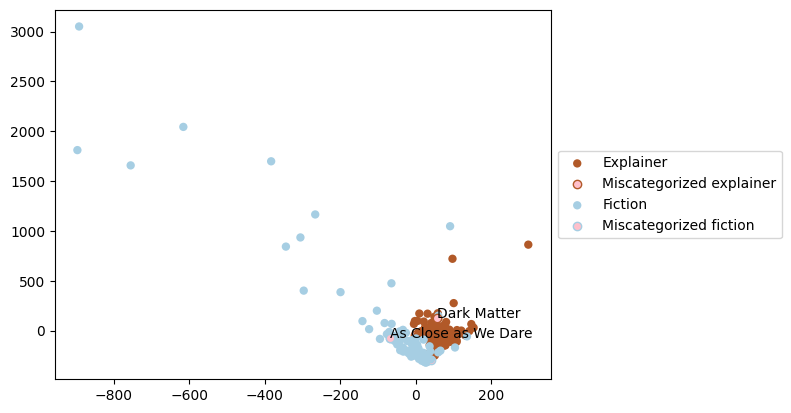

In [151]:
tag_accuracies, tag_miscategorized_files, tag_closest_vectors, tag_sim_values = run_k_cross_validation(explainer_common_tags_df, fiction_common_tags_df, verbose = True)

# More tests

## Dunning log likelihood on word counts



In [54]:
### comparing the statistical frequency of words in each corpus

explainer_pure_counts_dict = sort_top_words(explainer_dtm_df.iloc[:, 6:], normalize = False)
fiction_pure_counts_dict = sort_top_words(fiction_dtm_df.iloc[:, 6:], normalize = False)

dunning_comparison_words, dunning_values_words, = run_dunning_log_likelihood_test(explainer_pure_counts_dict, fiction_pure_counts_dict)
top_dunning_dict_words_desc, top_dunning_dict_words_asc = create_top_dunning_dict(dunning_values_words, length = 30)

In [66]:
print('Top 30 words (science explainers):\n')
top_dunning_dict_words_desc

Top 30 words (science explainers):



{'study': 5580.025421059754,
 'climate': 3563.185631680107,
 'research': 3465.1573753819603,
 'researcher': 3253.7455586974447,
 'scientist': 2812.620654932036,
 'health': 2425.309408064606,
 'university': 2374.466378751723,
 'specie': 2349.5518924630223,
 'data': 1851.1718163552014,
 'canada': 1766.2639218706327,
 'human': 1754.7917983461257,
 'change': 1546.1083488317727,
 'risk': 1346.5570681135284,
 'science': 1319.4956722336642,
 'million': 1316.9167454395706,
 'impact': 1247.4170623469613,
 'disease': 1238.5184746790167,
 'national': 1230.926292670977,
 'carbon': 1227.502161486048,
 'ha': 1158.9319868151683,
 'based': 1120.0684829765855,
 'team': 1092.0024920305038,
 'animal': 1062.6106724715046,
 'including': 1036.7519560211058,
 'global': 1035.149118539202,
 'according': 994.5388151173044,
 'published': 970.4381896461853,
 'environmental': 958.4075115879962,
 'population': 955.8411442532463,
 'temperature': 936.7127087688812}

In [65]:
print('Top 30 words (short stories):\n')
top_dunning_dict_words_asc

Top 30 words (short stories):



{'wa': -9840.33036448821,
 'mother': -2261.6082928863093,
 'father': -2041.5025304082028,
 'man': -1828.0174570702395,
 'didn': -1749.6014230404667,
 'hand': -1415.5778426475267,
 'door': -1204.8985773367133,
 'did': -1167.768244273509,
 'room': -1154.6646539529186,
 'boy': -1144.581182604431,
 'asked': -1140.8198712615927,
 'house': -1107.5745019910692,
 'knew': -1019.2991529828855,
 'know': -984.8551473410625,
 'head': -982.6454721185675,
 'felt': -961.5267116817364,
 'thought': -954.2626050215027,
 'like': -952.581124463904,
 'wanted': -919.0254710404631,
 'girl': -915.0105223925628,
 'went': -896.1636707477646,
 'tell': -875.6526456229028,
 'face': -870.5236839996028,
 'woman': -859.1700028223601,
 'night': -827.2030828753378,
 'looked': -826.9663023650298,
 'got': -788.1473430075921,
 'wife': -767.460834001947,
 'll': -750.0220523889813,
 'let': -728.4800734902414}

In [57]:
### preparing to do predictive modelling again

# the top 60 defining words from the respective corpora
top_60_words = list(top_dunning_dict_words_desc.keys()) + list(top_dunning_dict_words_asc.keys())

# dfs with only common words as column titles
explainer_top_words_df = refine_df_columns(explainer_dtm_df, top_60_words)
fiction_top_words_df = refine_df_columns(fiction_dtm_df, top_60_words)

In [58]:
### logistic regression with l2 regularization, 5-fold cross validation on tag frequency

top_words_accuracies, top_words_miscategorized_files, top_words_closest_vectors, top_words_sim_values = run_k_cross_validation(explainer_top_words_df, fiction_top_words_df)
top_words_avg_accuracy = round(sum(top_words_accuracies)/len(top_words_accuracies), 2)

print('The model was ' + str(top_words_avg_accuracy) + '% accurate (on average)')

The model was 98.66% accurate (on average)


In [59]:
top_words_accuracies

[99.44, 96.11, 99.44, 99.44, 98.89]

In [60]:
### finding closest miscateogrized files

top_words_sim = top_words_sim_values.index(max(top_words_sim_values))
top_words_1 = top_words_closest_vectors[top_words_sim][0]
top_words_2 = top_words_closest_vectors[top_words_sim][1]

print(f'The closest files are: \n\t{top_words_1} and \n\t{top_words_2} \nwith a cosine similarity of {max(top_words_sim_values)}')

The closest files are: 
	MASSIVE_SCI/DarkMatterMakesUpAQuarter.txt and 
	TIN_HOUSE/NaturalOrder.txt 
with a cosine similarity of 0.3499671046381734


## Dunning log likelihood + topic modelling

## Dunning log likelihood on verbs

## Dunning log likelihood on POS tags

In [61]:
### comparing the statistical frequency of words in each corpus

explainer_pure_pos_dict = sort_top_words(explainer_pos_df.iloc[:, 9:], normalize = False)
fiction_pure_pos_dict = sort_top_words(fiction_pos_df.iloc[:, 9:], normalize = False)

dunning_comparison_pos, dunning_values_pos, = run_dunning_log_likelihood_test(explainer_pure_pos_dict, fiction_pure_pos_dict)
top_dunning_dict_pos_desc, top_dunning_dict_pos_asc = create_top_dunning_dict(dunning_values_pos, length = 15)

In [67]:
### POS tags associated with science explainer corpus
print('Top 15 POS tags (science explainers):\n')
top_dunning_dict_pos_desc

Top 15 POS tags (science explainers):



{'NNS': 21760.6281917015,
 'CD': 6613.039143529279,
 'NNP': 5130.4600554325625,
 'POS': 4741.982076744441,
 'JJ': 3369.6783182861036,
 'VBZ': 3218.556339050927,
 'JJR': 2417.7164420526924,
 'WDT': 2335.607703333897,
 'IN': 1667.5106853350699,
 'NNPS': 1604.582961501133,
 'RBR': 1026.4570937808144,
 'JJS': 655.310095308324,
 'VBN': 513.2617484916518,
 'RBS': 470.53268677068615,
 'MD': 332.5171186622274}

In [68]:
### POS tags associated with short fiction corpus
print('Top 15 POS tags (short stories):\n')
top_dunning_dict_pos_asc

Top 15 POS tags (short stories):



{'PRP': -46320.77891296836,
 'VBD': -26336.026567843386,
 'PRP$': -13040.276514577181,
 'RP': -1575.2704498059793,
 'RB': -1065.6819441864463,
 'UH': -529.9823236867871,
 'WP': -358.9196823132338,
 'WRB': -274.0735662347638,
 'PDT': -246.87920259144562,
 'CC': -189.31592856545194,
 'FW': -85.6488511310958,
 'VB': -22.21861838888094,
 'WP$': -4.113230055418221,
 'NN': -2.5493220451248817,
 'EX': -0.5988371577817659}

# Stats testing

In [ ]:
from scipy.stats import mannwhitneyu

e_col = explainer_dtm_df.columns
f_col = fiction_dtm_df.columns

same_cols = list(set(e_col).intersection(set(f_col)))

explainer_stats = refine_df_columns(explainer_dtm_df, same_cols)
fiction_stats = refine_df_columns(fiction_dtm_df, same_cols)

e_val = explainer_stats.values.tolist()
f_val = fiction_stats.values.tolist()

U1, p = mannwhitneyu(e_val, f_val, method="exact")